In [2]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [3]:
import logging
from pathlib import Path

import altair as alt
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.signal as signal
import seaborn as sns
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.eda import detrend_tonic_component
from src.features.labels import add_labels
from src.features.resampling import (
    interpolate_and_fill_nulls,
    resample_to_equidistant_ms,
)
from src.features.scaling import scale_min_max
from src.features.transforming import map_trials, merge_dfs
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.plots.confidence_intervals import plot_confidence_intervals
from src.plots.correlations import (
    aggregate_correlations_fisher_z,
    calculate_correlations_by_trial,
    plot_correlations_by_participant,
    plot_correlations_by_trial,
)
from src.plots.utils import prepare_multiline_hvplot

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [4]:
db = DatabaseManager()

In [11]:
_exclude = True
with db:
    pupil = db.get_table("Feature_Pupil", _exclude)
    eda = db.get_table("Feature_EDA", _exclude)
    ppg = db.get_table("Feature_PPG", _exclude)
    stimulus = db.get_table("Feature_Stimulus", _exclude)
    trials = db.get_table("Trials", _exclude)

# Add detrended EDA
# different paradigms: statistics and statistical learning / non-causal and causal
eda = detrend_tonic_component(eda)

# Merge data dfs
df = merge_dfs([pupil, stimulus, eda, ppg])

# Merge with trial metadata and interpolate
df = merge_dfs(
    dfs=[df, trials],
    on=["trial_id", "participant_id", "trial_number"],
)
df = interpolate_and_fill_nulls(df)

# Rename columns
df = df.with_columns(col("pupil_mean").alias("pupil"))

# Equidistant resampling for cross-correlation lag calculation
df = resample_to_equidistant_ms(df, gather_every=10)
df_all = df

In [36]:
df = df_all.filter(col("participant_id") == 16)
df

timestamp,trial_id,trial_number,participant_id,rownumber,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,temperature,rating,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended,ppg_raw,ppg_heartrate,ppg_ibi,ppg_clean,ppg_rate,ppg_quality,ppg_peaks,heartrate,stimulus_seed,skin_area,timestamp_start,timestamp_end,duration,pupil
i64,u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,u16,u8,f64,f64,f64,f64
215575,177,1,16,null,4.474395,5.081918,5.090445,4.510077,4.800261,0.0,0.275,129793,27.71782,29.017062,-1.299241,0.567079,1408.058608,72,-1.0,11.701706,68.8953,0.978017,0,72.023497,806,6,215571.1105,395585.3796,180014.2691,4.800261
215585,177,1,16,12915,4.475251,5.085604,5.090397,4.510485,4.800441,0.0,0.275,129793,27.760359,29.019648,-1.259288,0.569705,1422.079033,72,-1.0,15.447779,68.8953,0.978017,0,72.023863,806,6,215571.1105,395585.3796,180014.2691,4.800441
215594,177,1,16,12916,4.476586,5.089727,5.090343,4.510943,4.800643,0.0,0.275,129793,27.799946,29.022054,-1.222109,0.572148,1427.838828,72,-1.0,24.982005,68.8953,0.978017,0,72.024821,806,6,215571.1105,395585.3796,180014.2691,4.800643
215604,177,1,16,12916,4.483116,5.094024,5.090273,4.511436,4.800855,0.0,0.275,129793,27.843166,29.024682,-1.181516,0.574816,1430.455199,72,-1.0,29.079189,68.8953,0.978017,0,72.025276,806,6,215571.1105,395585.3796,180014.2691,4.800855
215614,177,1,16,12917,4.486312,5.096747,5.090197,4.511932,4.801064,0.00002,0.279223,129793,27.886533,29.027319,-1.140785,0.577493,1434.858547,72,-1.0,36.341653,68.8953,0.978017,0,72.026162,806,6,215571.1105,395585.3796,180014.2691,4.801064
215624,177,1,16,12917,4.484321,5.096988,5.090116,4.512416,4.801266,0.00004,0.283349,129793,27.928897,29.029894,-1.100997,0.580108,1437.115243,72,-1.0,37.570734,68.8953,0.978017,0,72.026329,806,6,215571.1105,395585.3796,180014.2691,4.801266
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2810586,188,12,16,168440,2.690322,3.486348,3.764436,2.817908,3.291172,0.275474,0.88625,461960,36.221563,37.643069,-0.096233,-0.170621,1462.393162,67,-1.0,4.356218,63.829787,0.979189,0,66.94455,396,1,2.6306e6,2.8106e6,180029.4308,3.291172
2810596,188,12,16,168441,2.688395,3.495482,3.76441,2.817901,3.291156,0.275474,0.88625,461960,36.221563,37.643069,-0.096233,-0.170621,1477.914442,67,-1.0,10.165162,63.829787,0.979189,0,66.935386,396,1,2.6306e6,2.8106e6,180029.4308,3.291156


(-0.7566666666666665, 0.40445998416144807)

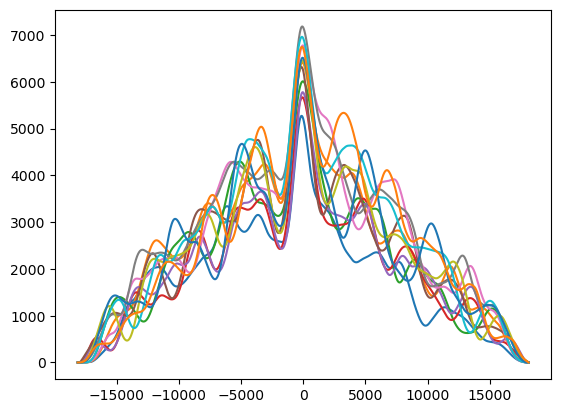

In [ ]:
col1 = "temperature"
col2 = "rating"

lag_arr = []
trial_ids = []
for trial in df["trial_id"].unique().to_numpy():
    temperature = df.filter(col("trial_id") == trial)[col1].to_numpy()
    rating = df.filter(col("trial_id") == trial)[col2].to_numpy()

    # Cross-correlation
    corr = signal.correlate(
        temperature,
        rating,
        method="auto",
    )
    # Lag indices for the cross-correlation with 0 at the center
    lags = signal.correlation_lags(
        len(temperature),
        len(rating),
    )
    plt.plot(lags, corr)

    # Find the maximum correlation and the lag
    lag = lags[np.argmax(corr)] * 10 / 1000  # ms to s
    lag_arr.append(lag)
    trial_ids.append(trial)

lag_arr = np.array(lag_arr)
lag_df = pl.DataFrame({"trial_id": trial_ids, "lag": lag_arr})

lag_df["lag"].mean(), lag_df["lag"].std()

In [47]:
lag_df.sort("lag")

trial_id,lag
u16,f64
182,-1.51
177,-1.32
186,-1.06
188,-1.03
184,-0.82
178,-0.73
180,-0.71
187,-0.51
181,-0.43


In [49]:
df.hvplot(
    x="timestamp",
    y=["temperature", "rating"],
    groupby="trial_id",
    width=800,
    height=400,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f17d3771-73fe-4a02-8fdb-e5f75a64ec8f': {'version…

In [84]:
df.filter(col("trial_id") == 73).hvplot(x="timestamp", y=["rating", "pupil"])

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

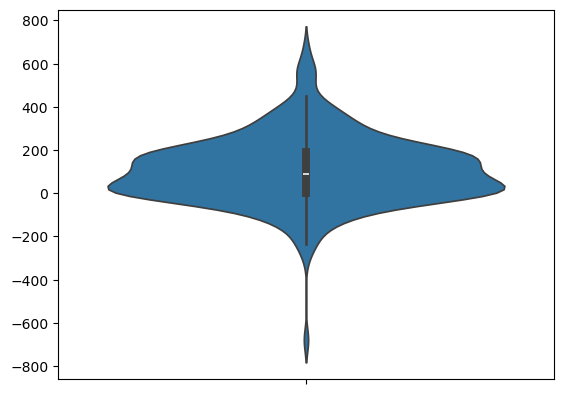

In [68]:
# lag_df.boxplot()
lag_arr.mean(), lag_arr.std()

sns.violinplot(data=lag_df["lag"].to_numpy())
plt.show()

In [80]:
df

timestamp,trial_id,trial_number,participant_id,rownumber,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,temperature,rating,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended,ppg_raw,ppg_heartrate,ppg_ibi,ppg_clean,ppg_rate,ppg_quality,ppg_peaks,heartrate,random_walk,stimulus_seed,skin_area,timestamp_start,timestamp_end,duration,pupil
i64,u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64,u16,u8,f64,f64,f64,f64
184809,25,1,3,null,4.068285,4.544422,4.593287,4.125571,4.359429,0.0,0.93625,204865,3.855469,4.417003,-0.561535,-2.373273,1334.798535,70,-1.0,17.229447,62.206107,0.914015,0,70.126429,0.440488,658,1,184806.3783,364835.4139,180029.0356,4.359429
184819,25,1,3,11073,4.069697,4.545542,4.59388,4.126116,4.359998,0.0,0.93625,204865,3.857443,4.418739,-0.561297,-2.371537,1317.277167,70,-1.0,11.777582,62.206107,0.914015,0,70.126404,-0.680352,658,1,184806.3783,364835.4139,180029.0356,4.359998
184829,25,1,3,11074,4.071337,4.546547,4.59454,4.126722,4.360631,0.0,0.93625,204865,3.859284,4.420358,-0.561074,-2.369918,1326.236544,70,-1.0,10.564054,62.206107,0.914015,0,70.126133,-0.872736,658,1,184806.3783,364835.4139,180029.0356,4.360631
184839,25,1,3,11074,4.073778,4.545605,4.595288,4.127405,4.361346,0.000003,0.93625,204865,3.861391,4.422211,-0.56082,-2.368066,1345.787546,70,-1.0,13.067184,62.206107,0.914015,0,70.125386,-1.732998,658,1,184806.3783,364835.4139,180029.0356,4.361346
184848,25,1,3,11075,4.076484,4.544731,4.595922,4.127983,4.361952,0.000013,0.93625,204865,3.863171,4.423777,-0.560605,-2.3665,1341.87422,70,-1.0,20.2989,62.206107,0.914015,0,70.1243,-3.347512,658,1,184806.3783,364835.4139,180029.0356,4.361952
184858,25,1,3,11075,4.08037,4.543655,4.596628,4.128622,4.362625,0.000024,0.93625,204865,3.86514,4.425508,-0.560368,-2.364768,1368.498168,70,-1.0,28.041371,62.206107,0.914015,0,70.123326,-4.303051,658,1,184806.3783,364835.4139,180029.0356,4.362625
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2777077,332,12,28,166438,4.121765,4.015851,3.981262,4.025713,4.003487,0.155438,0.85,467067,13.521901,13.423457,-0.013555,1.36641,1802.938179,72,-1.0,113.323901,65.934066,0.987849,0,72.405134,277.982268,133,1,2.5971e6,2.7771e6,180026.123,4.003487
2777087,332,12,28,166438,4.115157,4.00901,3.981225,4.025659,4.003442,0.155438,0.85,467067,13.523057,13.423457,-0.012879,1.366762,1802.647306,72,-1.0,103.828674,65.934066,0.987849,0,72.402666,278.734176,133,1,2.5971e6,2.7771e6,180026.123,4.003442


In [29]:
lag_arr = lag_arr[lag_arr < -100]

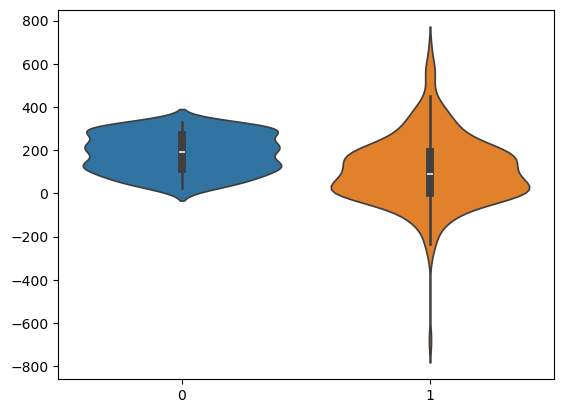

In [81]:
# violin plot using seaborn

sns.violinplot(data=lag_df)
plt.show()

(np.float64(-31.280155642023345), np.float64(276.1181571137862))

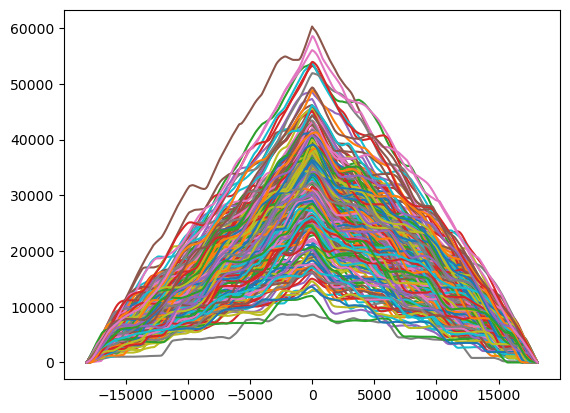

In [43]:
lag_arr = []
for trial in df["trial_id"].unique().to_numpy():
    temperature = df.filter(col("trial_id") == trial)["rating"].to_numpy()
    rating = df.filter(col("trial_id") == trial)["pupil"].to_numpy()

    corr = signal.correlate(
        temperature,
        rating,
    )
    lags = signal.correlation_lags(
        len(temperature),
        len(rating),
    )
    plt.plot(lags, corr)
    lag = lags[np.argmax(corr)]
    lag_arr.append(lag)
np.array(lag_arr).mean(), np.array(lag_arr).std()

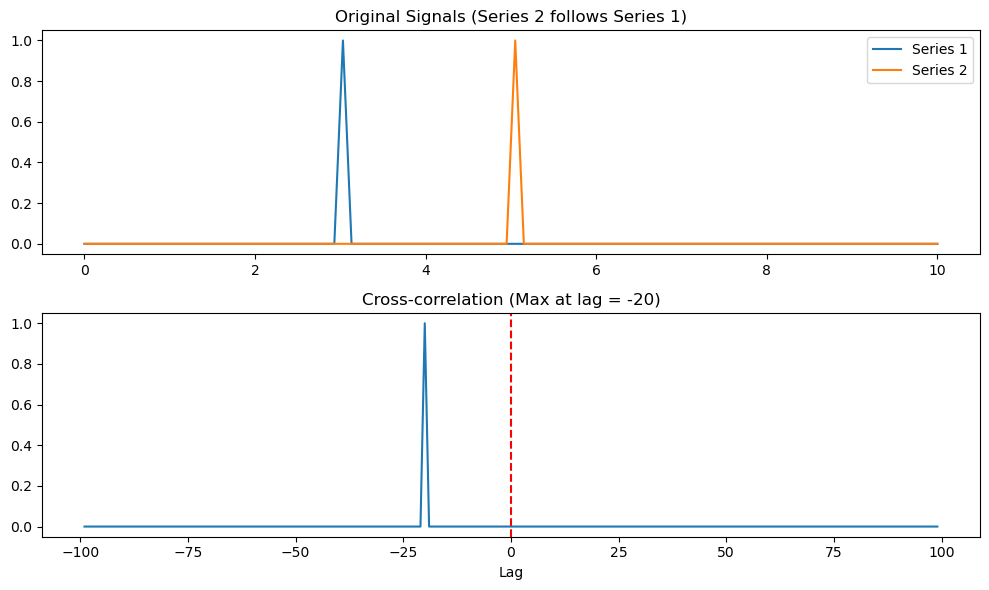

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Create two simple signals where series2 clearly follows series1
t = np.linspace(0, 10, 100)
shift = 20  # 20 points shift
series1 = np.zeros(100)
series2 = np.zeros(100)

# Put a pulse in series1 at t=30
series1[30] = 1

# Put the same pulse in series2 at t=50 (20 points later)
series2[50] = 1

# Calculate cross-correlation
correlation = signal.correlate(series1, series2)
lags = signal.correlation_lags(len(series1), len(series2))

# Find the lag with maximum correlation
max_corr_lag = lags[np.argmax(correlation)]

# Plot both series and correlation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(t, series1, label="Series 1")
ax1.plot(t, series2, label="Series 2")
ax1.legend()
ax1.set_title("Original Signals (Series 2 follows Series 1)")

ax2.plot(lags, correlation)
ax2.axvline(x=0, color="r", linestyle="--")
ax2.set_title(f"Cross-correlation (Max at lag = {max_corr_lag})")
ax2.set_xlabel("Lag")
plt.tight_layout()
plt.show()


In [6]:
df.filter(col("trial_id") == 1).with_columns(col("timestamp").diff().std())

trial_id,trial_number,participant_id,rownumber,timestamp,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,temperature,rating,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended,ppg_raw,ppg_heartrate,ppg_ibi,ppg_clean,ppg_rate,ppg_quality,ppg_peaks,heartrate,random_walk,stimulus_seed,skin_area,timestamp_start,timestamp_end,duration,pupil
u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,f64,u16,u8,f64,f64,f64,f64
1,1,1,17631,4.719584,5.73628,6.245389,5.640989,5.183107,5.412048,0.0,0.425,null,0.743774,0.743503,0.000271,-0.000092,1424.175824,null,-1.0,-14.227641,65.896546,0.975548,null,65.999319,-1.820131,396,1,294197.3945,474206.7098,180009.3153,5.412048
1,1,1,null,4.719584,5.729314,6.242299,5.640126,5.18257,5.411348,0.0,0.425,57892,0.743774,0.743503,0.000271,-0.000092,1424.175824,-1,-1.0,-14.227641,65.896546,0.975548,0,65.999319,-2.892217,396,1,294197.3945,474206.7098,180009.3153,5.411348
1,1,1,null,4.719584,5.728704,6.242028,5.64005,5.182523,5.411286,0.0,0.425,null,0.743784,0.743503,0.00028,-0.000092,1438.095238,-1,-1.0,-16.831259,65.896546,0.975548,0,65.999213,-3.298196,396,1,294197.3945,474206.7098,180009.3153,5.411286
1,1,1,17632,4.719584,5.726105,6.240875,5.639728,5.182322,5.411025,0.0,0.425,null,0.743825,0.743504,0.000321,-0.000091,1439.054647,null,-1.0,-17.843339,65.896546,0.975548,null,65.999177,-4.930338,396,1,294197.3945,474206.7098,180009.3153,5.411025
1,1,1,null,4.719584,5.718118,6.236929,5.639069,5.181911,5.41049,0.0,0.425,null,0.743911,0.743505,0.000405,-0.00009,1441.025641,-1,-1.0,-19.922539,65.896546,0.975548,0,65.999102,-5.7364,396,1,294197.3945,474206.7098,180009.3153,5.41049
1,1,1,17633,4.719584,5.710716,6.233272,5.638458,5.18153,5.409994,0.000004,0.425,null,0.74399,0.743506,0.000483,-0.000089,1425.838269,null,-1.0,-21.676652,65.896546,0.975548,null,65.99905,-4.568274,396,1,294197.3945,474206.7098,180009.3153,5.409994
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,1,1,28418,4.719584,3.476228,3.00741,4.732467,4.341238,4.536852,0.275474,0.0,null,0.745661,0.746054,0.00215,0.00229,1431.229234,null,-1.0,30.680541,82.191781,0.880908,null,75.818711,-66.909227,396,1,294197.3945,474206.7098,180009.3153,4.536852
1,1,1,28419,4.719584,3.583754,3.12582,4.731963,4.340873,4.536418,0.275474,0.0,null,0.745661,0.746054,0.00215,0.00229,1457.284924,null,-1.0,28.707806,82.191781,0.880908,null,75.836589,-69.028744,396,1,294197.3945,474206.7098,180009.3153,4.536418


np.int64(124)

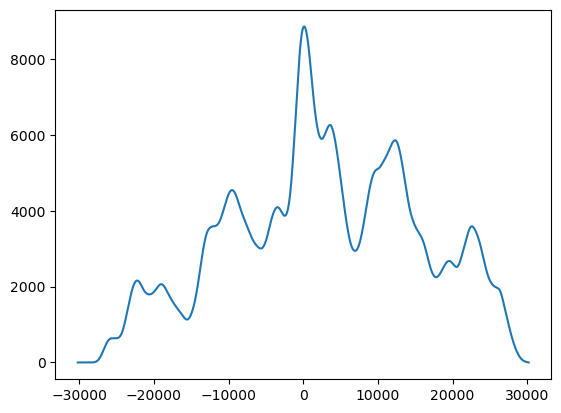

In [7]:
trial = 84
rating = df.filter(col("trial_id") == trial)["rating"].to_numpy()
temperature = df.filter(col("trial_id") == trial)["temperature"].to_numpy()

corr = signal.correlate(
    temperature,
    rating,
)
lags = signal.correlation_lags(len(temperature), len(rating))
plt.plot(lags, corr)
lag = lags[np.argmax(corr)]
lag

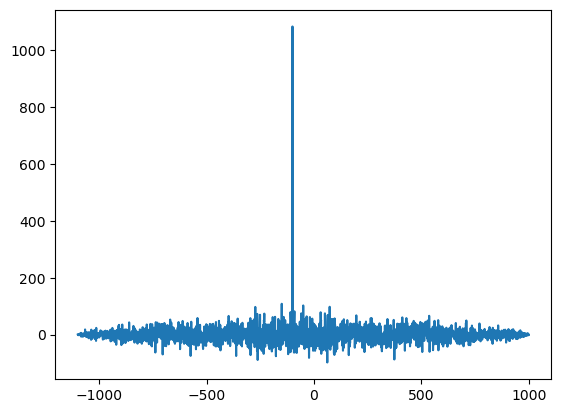

In [8]:
import numpy as np
from scipy import signal

rng = np.random.default_rng()

x = rng.standard_normal(1000)

y = np.concatenate([rng.standard_normal(100), x])

correlation = signal.correlate(x, y, mode="full")

lags = signal.correlation_lags(x.size, y.size, mode="full")

lag = lags[np.argmax(correlation)]
plt.plot(lags, correlation)

In [9]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=[
        "eda_raw",
        "eda_phasic",
        "eda_tonic",
        # "pupil",
        # "rating",
        "temperature",
        # "pupil_r_raw",
        # "pupil_l_raw",
    ],
    groupby=["participant_id", "trial_number"],
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8c73b42c-b1f1-47bf-ae49-79f8a9c83634': {'version…